--- Installing required libraries... ---
--- Gerekli kütüphaneler yükleniyor... ---
--- Libraries installed and imported. ---
--- Kütüphaneler yüklendi ve içe aktarıldı. ---

--- Please select the NASAPOWERDATASET.csv file for upload: ---
--- Lütfen yüklemek için NASAPOWERDATASET.csv dosyasını seçin: ---


Saving NASAPOWERDATASET (1).csv to NASAPOWERDATASET (1).csv

--- Data successfully loaded and prepared. ---
--- Veri başarıyla yüklendi ve hazırlandı. ---

--- Starting Return Period Analysis (Gumbel)... ---
--- Tekerrür Analizi (Gumbel) Başlatılıyor... ---
--- Return period analysis complete. Downloading 'design_rainfall_table.csv'... ---
--- Tekerrür analizi tamamlandı. 'design_rainfall_table.csv' indiriliyor... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Starting Trend Analysis (Theil-Sen)... ---
--- Trend Analizi (Theil-Sen) Başlatılıyor... ---
--- Trend analysis complete. Downloading 'trend_analysis_ai.png'... ---
--- Trend analizi tamamlandı. 'trend_analysis_ai.png' indiriliyor... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Starting Automated Feature Selection... ---
--- Otomatik Özellik Seçimi Başlatılıyor... ---
--- Top 6 features selected. Downloading 'feature_importance.png'... ---
--- En önemli 6 özellik seçildi. 'feature_importance.png' indiriliyor... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Starting Final Model Competition (This may take a very long time)... ---
--- Nihai Model Yarışması Başlatılıyor (Bu işlem ÇOK UZUN sürebilir)... ---

1. Training All 11 Models...
1. Tüm 11 Model Eğitiliyor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 7013, number of used features: 6
[LightGBM] [Info] Start training from score 2.297661


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc2pk0wr7/pc1y48k5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc2pk0wr7/9akeload.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53099', 'data', 'file=/tmp/tmpc2pk0wr7/pc1y48k5.json', 'init=/tmp/tmpc2pk0wr7/9akeload.json', 'output', 'file=/tmp/tmpc2pk0wr7/prophet_modelcpsuvlry/prophet_model-20250925130536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:05:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:05:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc2pk0wr7/lrdqxeyn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc2pk0wr7/w2piz3av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21756', 'data', 'file=/tmp/tmpc2pk0wr7/lrdqxeyn.json', 'init=/tmp/tmpc2pk0wr7/w2piz3av.json', 'output', 'file=/tmp/tmpc2pk0wr7/prophet_modellc38980e/prophet_model-20250925130753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:07:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:07:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 7013, number of used features: 6
[LightGBM] [Info] Start training from score 2.297661
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 5610, number of used features: 6
[LightGBM] [Info] Start training from score 2.248321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 56

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Downloading performance bar chart 'model_performance_barchart.png'... ---
--- Performans bar grafiği 'model_performance_barchart.png' indiriliyor... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Downloading final comparison plot 'ULTIMATE_FINAL_comparison.png'... ---
--- Nihai karşılaştırma grafiği 'ULTIMATE_FINAL_comparison.png' indiriliyor... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Downloading champion model scatter plot 'champion_model_scatter.png'... ---
--- Şampiyon modelin dağılım grafiği 'champion_model_scatter.png' indiriliyor... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Creating All Architectural Diagrams... ---
--- Tüm Mimari Şemaları Oluşturuluyor... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--- Downloading all architectural diagrams... ---
--- Tüm mimari şemaları indiriliyor... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



=== ALL ANALYSES AND VISUALIZATIONS COMPLETED ===
=== TÜM ANALİZLER VE GÖRSELLEŞTİRMELER TAMAMLANDI ===


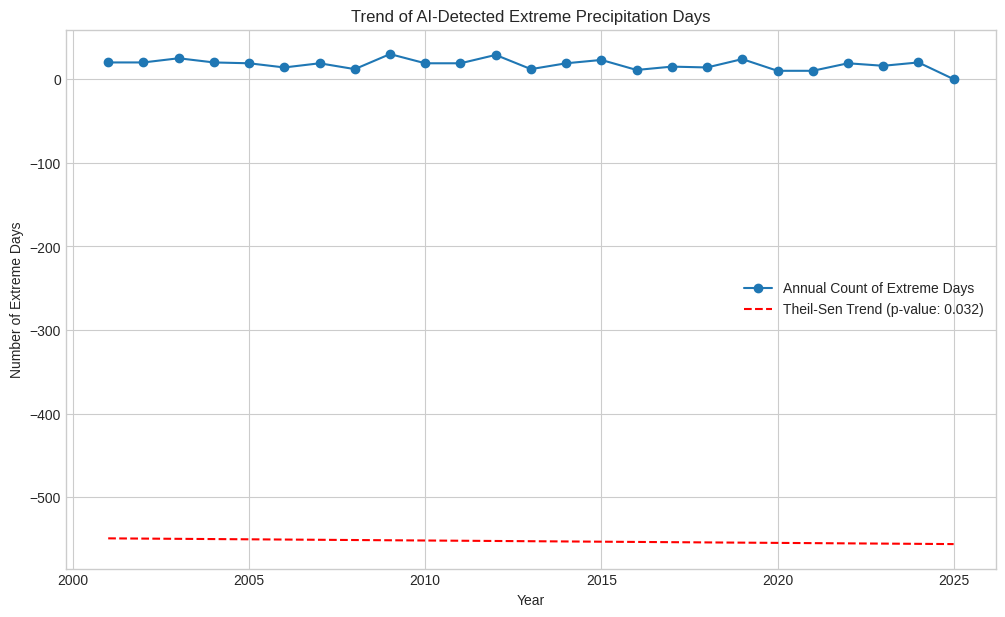

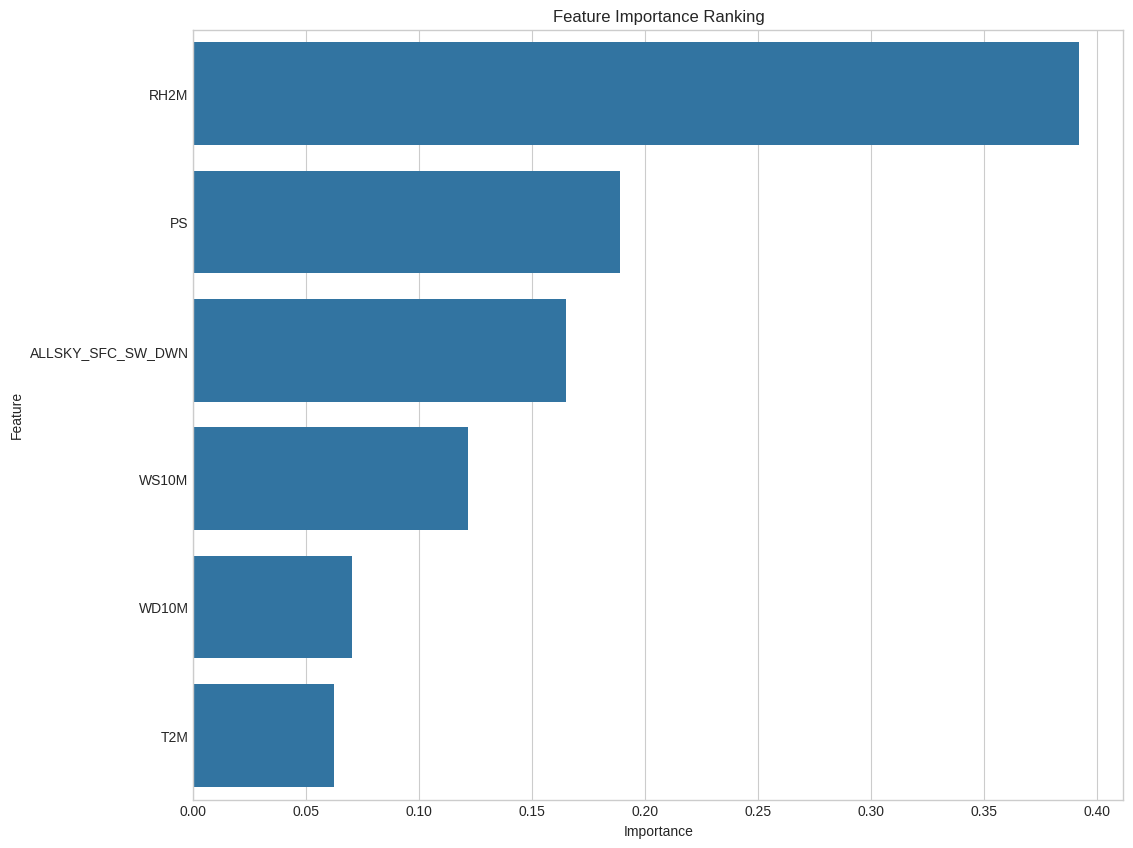

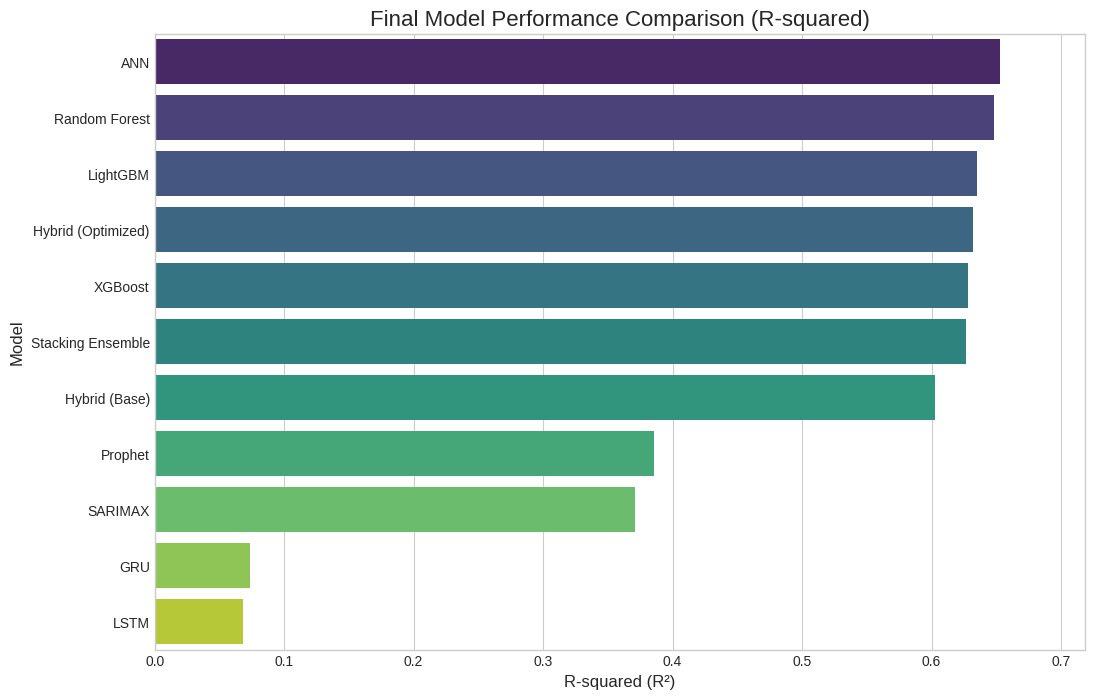

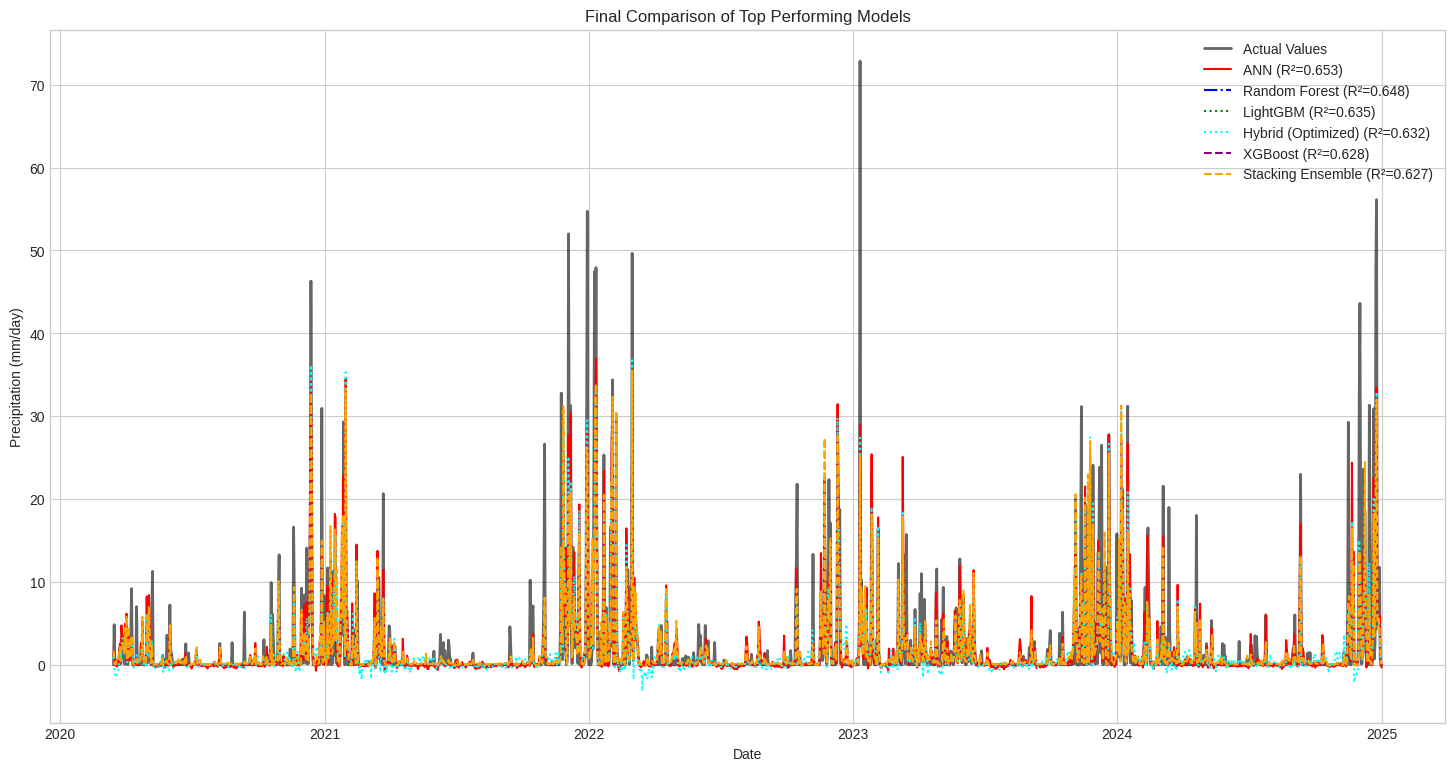

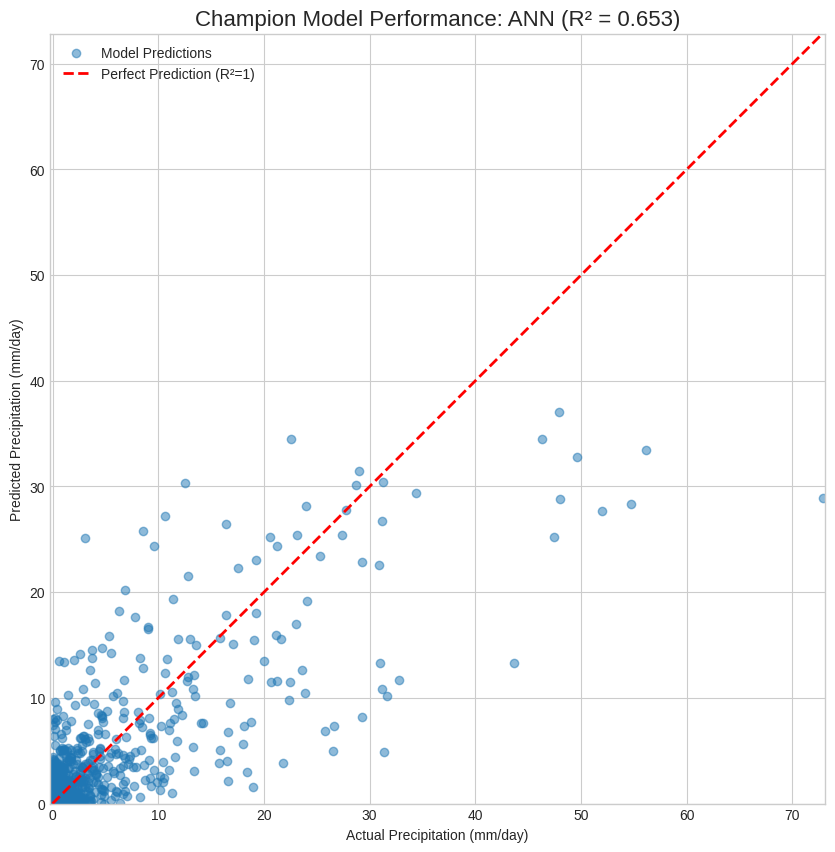

In [1]:
# ==============================================================================
# AUTHOR AND LICENSE INFORMATION
# ==============================================================================
# This code was developed by Dr. Tevfik Denizhan Müftüoğlu.
# It can be used and/or modified with the condition of providing proper citation.
#
# Bu kod Dr. Tevfik Denizhan Müftüoğlu tarafından geliştirilmiştir.
# Atıf verilmesi kaydıyla aynen ya da değiştirilerek kullanılabilir.
# ==============================================================================

# ==============================================================================
# STEP 1: INSTALL AND IMPORT LIBRARIES
# Adım 1: Kütüphaneleri Yükleme ve İçe Aktarma
# ==============================================================================
print("--- Installing required libraries... ---")
print("--- Gerekli kütüphaneler yükleniyor... ---")
!pip install pymannkendall -q
!pip install prophet -q
!pip install xgboost -q
!pip install lightgbm -q
!pip install graphviz -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymannkendall as mk
from scipy.stats import gumbel_r
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Models and Metrics
from sklearn.ensemble import IsolationForest, RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from graphviz import Digraph
print("--- Libraries installed and imported. ---")
print("--- Kütüphaneler yüklendi ve içe aktarıldı. ---")

# ==============================================================================
# STEP 2: LOAD AND PREPARE THE DATA
# Adım 2: Veriyi Yükleme ve Hazırlama
# ==============================================================================
print("\n--- Please select the NASAPOWERDATASET.csv file for upload: ---")
print("--- Lütfen yüklemek için NASAPOWERDATASET.csv dosyasını seçin: ---")
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(file_name)
df['date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['DOY'].astype(str), format='%Y-%j')
df.set_index('date', inplace=True)
print("\n--- Data successfully loaded and prepared. ---")
print("--- Veri başarıyla yüklendi ve hazırlandı. ---")
plt.style.use('seaborn-v0_8-whitegrid')

# ==============================================================================
# ANALYSIS PART A: INDEPENDENT STATISTICAL ANALYSES
# ANALİZ BÖLÜM A: BAĞIMSIZ İSTATİSTİKSEL ANALİZLER
# ==============================================================================
print("\n--- Starting Return Period Analysis (Gumbel)... ---")
print("--- Tekerrür Analizi (Gumbel) Başlatılıyor... ---")
annual_max_precip = df['PRECTOTCORR'].resample('Y').max()
loc, scale = gumbel_r.fit(annual_max_precip)
return_periods = np.array([2, 5, 10, 25, 50, 100])
design_precip = gumbel_r.ppf(1 - 1 / return_periods, loc=loc, scale=scale)
results_df_gumbel = pd.DataFrame({'Tekerrür Periyodu (Yıl)': return_periods, 'Tasarım Yağışı (mm/gün)': design_precip.round(2)})
results_df_gumbel.to_csv('design_rainfall_table.csv', index=False)
print("--- Return period analysis complete. Downloading 'design_rainfall_table.csv'... ---")
print("--- Tekerrür analizi tamamlandı. 'design_rainfall_table.csv' indiriliyor... ---")
files.download('design_rainfall_table.csv')

print("\n--- Starting Trend Analysis (Theil-Sen)... ---")
print("--- Trend Analizi (Theil-Sen) Başlatılıyor... ---")
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['is_extreme'] = (iso_forest.fit_predict(df[['PRECTOTCORR']]) == -1)
extreme_events_per_year = df['is_extreme'].resample('Y').sum()
mk_result = mk.original_test(extreme_events_per_year)
plt.figure(figsize=(12, 7))
plt.plot(extreme_events_per_year.index.year, extreme_events_per_year, marker='o', label='Annual Count of Extreme Days')
trend_line = mk_result.intercept + mk_result.slope * (extreme_events_per_year.index.year)
plt.plot(extreme_events_per_year.index.year, trend_line, 'r--', label=f'Theil-Sen Trend (p-value: {mk_result.p:.3f})')
plt.title('Trend of AI-Detected Extreme Precipitation Days'); plt.xlabel('Year'); plt.ylabel('Number of Extreme Days'); plt.legend()
plt.savefig('trend_analysis_ai.png', dpi=300, bbox_inches='tight')
print("--- Trend analysis complete. Downloading 'trend_analysis_ai.png'... ---")
print("--- Trend analizi tamamlandı. 'trend_analysis_ai.png' indiriliyor... ---")
files.download('trend_analysis_ai.png')

# ==============================================================================
# ANALYSIS PART B: AUTOMATED FEATURE SELECTION & MODEL COMPETITION
# ANALİZ BÖLÜM B: OTOMATİK ÖZELLİK SEÇİMİ VE MODEL YARIŞMASI
# ==============================================================================
print("\n--- Starting Automated Feature Selection... ---")
print("--- Otomatik Özellik Seçimi Başlatılıyor... ---")
POTENTIAL_FEATURES = ['T2M', 'RH2M', 'PS', 'WS10M', 'WD10M', 'ALLSKY_SFC_SW_DWN']
TARGET_COL = 'PRECTOTCORR'
df_fs = df[[TARGET_COL] + POTENTIAL_FEATURES].copy().dropna()
for col in df_fs.columns: [df_fs.update({f'{col}_lag_{lag}': df_fs[col].shift(lag)}) for lag in range(1, 4)]
df_fs = df_fs.dropna()
X_fs = df_fs.drop(TARGET_COL, axis=1)
y_fs = df_fs[TARGET_COL]
explorer_model = xgb.XGBRegressor(n_estimators=100, n_jobs=-1).fit(X_fs, y_fs, verbose=False)
importances = pd.DataFrame({'feature': X_fs.columns, 'importance': explorer_model.feature_importances_}).sort_values('importance', ascending=False)
TOP_FEATURES = importances['feature'].head(15).tolist()
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=importances.head(15)); plt.title('Feature Importance Ranking'); plt.xlabel('Importance'); plt.ylabel('Feature')
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print(f"--- Top {len(TOP_FEATURES)} features selected. Downloading 'feature_importance.png'... ---")
print(f"--- En önemli {len(TOP_FEATURES)} özellik seçildi. 'feature_importance.png' indiriliyor... ---")
files.download('feature_importance.png')

print("\n--- Starting Final Model Competition (This may take a very long time)... ---")
print("--- Nihai Model Yarışması Başlatılıyor (Bu işlem ÇOK UZUN sürebilir)... ---")
# Data Prep
df_final = df[[TARGET_COL] + POTENTIAL_FEATURES].copy()
train_size = int(len(df_final) * 0.8)
train_df, test_df = df_final.iloc[:train_size], df_final.iloc[train_size:]
y_test_actual = test_df[TARGET_COL]
performance_results = []
X_train_tree, y_train_tree = X_fs.loc[train_df.index.min():train_df.index.max(), TOP_FEATURES], y_fs.loc[train_df.index.min():train_df.index.max()]
X_test_tree, y_test_tree = X_fs.loc[test_df.index.min():test_df.index.max(), TOP_FEATURES], y_fs.loc[test_df.index.min():test_df.index.max()]

# --- Model Training ---
print("\n1. Training All 11 Models...")
print("1. Tüm 11 Model Eğitiliyor...")
# Tree-based Models
model_xgb = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, eval_metric='rmse').fit(X_train_tree, y_train_tree, eval_set=[(X_test_tree, y_test_tree)], verbose=False)
predict_xgb = model_xgb.predict(X_test_tree)
performance_results.append({'Model': 'XGBoost', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_tree, predict_xgb)), 'R-Kare (R²)': r2_score(y_test_tree, predict_xgb)})
model_lgbm = lgb.LGBMRegressor(n_estimators=1000, random_state=42); model_lgbm.fit(X_train_tree, y_train_tree, eval_set=[(X_test_tree, y_test_tree)], callbacks=[lgb.early_stopping(50, verbose=False)])
predict_lgbm = model_lgbm.predict(X_test_tree)
performance_results.append({'Model': 'LightGBM', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_tree, predict_lgbm)), 'R-Kare (R²)': r2_score(y_test_tree, predict_lgbm)})
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train_tree, y_train_tree)
predict_rf = model_rf.predict(X_test_tree)
performance_results.append({'Model': 'Random Forest', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_tree, predict_rf)), 'R-Kare (R²)': r2_score(y_test_tree, predict_rf)})
# Prophet
FEATURES_FOR_PROPHET = [f for f in TOP_FEATURES if f in POTENTIAL_FEATURES and f in df_final.columns]
prophet_df = df_final.reset_index().rename(columns={'date': 'ds', TARGET_COL: 'y'})
train_prophet, test_prophet = prophet_df.iloc[:train_size], prophet_df.iloc[train_size:]
model_prophet = Prophet(); [model_prophet.add_regressor(col) for col in FEATURES_FOR_PROPHET]
model_prophet.fit(train_prophet)
predict_prophet = model_prophet.predict(test_prophet.drop('y', axis=1))['yhat'].values
performance_results.append({'Model': 'Prophet', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_actual, predict_prophet)), 'R-Kare (R²)': r2_score(y_test_actual, predict_prophet)})
# SARIMAX
X_sarimax_train = train_df[POTENTIAL_FEATURES]; X_sarimax_test = test_df[POTENTIAL_FEATURES]
model_sarimax = SARIMAX(train_df[TARGET_COL], exog=X_sarimax_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)).fit(disp=False)
predict_sarimax = model_sarimax.get_forecast(steps=len(test_df), exog=X_sarimax_test).predicted_mean
performance_results.append({'Model': 'SARIMAX', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_actual, predict_sarimax)), 'R-Kare (R²)': r2_score(y_test_actual, predict_sarimax)})
# ANN
scaler_ann = StandardScaler(); X_train_ann = scaler_ann.fit_transform(X_train_tree); X_test_ann = scaler_ann.transform(X_test_tree)
model_ann = Sequential([Dense(64, activation='relu', input_shape=[X_train_ann.shape[1]]), Dense(32, activation='relu'), Dense(1)])
model_ann.compile(optimizer='adam', loss='mean_squared_error'); model_ann.fit(X_train_ann, y_train_tree, epochs=50, batch_size=32, verbose=0)
predict_ann = model_ann.predict(X_test_ann).flatten()
performance_results.append({'Model': 'ANN', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_tree, predict_ann)), 'R-Kare (R²)': r2_score(y_test_tree, predict_ann)})
# LSTM & GRU
FEATURES_FOR_DL = [TARGET_COL] + [f for f in TOP_FEATURES if f in POTENTIAL_FEATURES and f in df_final.columns]
scaler_dl = MinMaxScaler(); scaled_data = scaler_dl.fit_transform(df_final[FEATURES_FOR_DL])
train_scaled, test_scaled = scaled_data[:train_size], scaled_data[train_size:]
def create_multivariate_dataset(dataset, time_step=30):
    dataX, dataY = [], []; [dataX.append(dataset[i:(i + time_step), :]) or dataY.append(dataset[i + time_step, 0]) for i in range(len(dataset) - time_step - 1)]; return np.array(dataX), np.array(dataY)
time_step = 30
X_train_dl, y_train_dl = create_multivariate_dataset(train_scaled, time_step); X_test_dl, _ = create_multivariate_dataset(test_scaled, time_step)
model_lstm = Sequential([LSTM(50, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])), Dense(1)]); model_lstm.compile(optimizer='adam', loss='mean_squared_error'); model_lstm.fit(X_train_dl, y_train_dl, epochs=20, batch_size=64, verbose=0)
predict_lstm_scaled = model_lstm.predict(X_test_dl)
model_gru = Sequential([GRU(50, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])), Dense(1)]); model_gru.compile(optimizer='adam', loss='mean_squared_error'); model_gru.fit(X_train_dl, y_train_dl, epochs=20, batch_size=64, verbose=0)
predict_gru_scaled = model_gru.predict(X_test_dl)
dummy_lstm = np.zeros((len(predict_lstm_scaled), len(FEATURES_FOR_DL))); dummy_lstm[:,0] = predict_lstm_scaled.flatten(); predict_lstm = scaler_dl.inverse_transform(dummy_lstm)[:,0]
dummy_gru = np.zeros((len(predict_gru_scaled), len(FEATURES_FOR_DL))); dummy_gru[:,0] = predict_gru_scaled.flatten(); predict_gru = scaler_dl.inverse_transform(dummy_gru)[:,0]
y_test_dl_actual = y_test_actual.iloc[time_step+1:]
performance_results.append({'Model': 'LSTM', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_dl_actual, predict_lstm)), 'R-Kare (R²)': r2_score(y_test_dl_actual, predict_lstm)})
performance_results.append({'Model': 'GRU', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_dl_actual, predict_gru)), 'R-Kare (R²)': r2_score(y_test_dl_actual, predict_gru)})
# Hybrid Models (Base and Optimized)
df_hybrid = df_final.reset_index().rename(columns={'date':'ds', TARGET_COL:'y'})
train_hybrid_prophet = df_hybrid.iloc[:train_size]
model_prophet_base = Prophet().fit(train_hybrid_prophet[['ds', 'y']])
full_forecast = model_prophet_base.predict(df_hybrid[['ds']])
df_hybrid['prophet_forecast'] = full_forecast['yhat']
df_hybrid['residuals'] = df_hybrid['y'] - df_hybrid['prophet_forecast']
df_temp_for_lags = df_final.copy()
for col in [TARGET_COL] + POTENTIAL_FEATURES: [df_temp_for_lags.update({f'{col}_lag_{lag}': df_temp_for_lags[col].shift(lag)}) for lag in range(1, 4)]
df_temp_for_lags = df_temp_for_lags.dropna()
df_hybrid_xgb = df_temp_for_lags.reset_index().rename(columns={'date':'ds'})
df_hybrid_xgb = pd.merge(df_hybrid_xgb, df_hybrid[['ds', 'prophet_forecast', 'residuals']], on='ds', how='inner').set_index('ds')
FEATURES_HYBRID = [f for f in df_hybrid_xgb.columns if f not in ['y', 'residuals', 'prophet_forecast', 'ds', TARGET_COL]]
TARGET_HYBRID = 'residuals'
train_size_hybrid = int(len(df_hybrid_xgb) * 0.8)
X_train_h, X_test_h = df_hybrid_xgb.iloc[:train_size_hybrid][FEATURES_HYBRID], df_hybrid_xgb.iloc[train_size_hybrid:][FEATURES_HYBRID]
y_train_h, y_test_h = df_hybrid_xgb.iloc[:train_size_hybrid][TARGET_HYBRID], df_hybrid_xgb.iloc[train_size_hybrid:][TARGET_HYBRID]
prophet_test_forecast = df_hybrid_xgb['prophet_forecast'].iloc[train_size_hybrid:]
y_test_hybrid_actual = y_test_h + prophet_test_forecast
model_xgb_hybrid_base = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, eval_metric='rmse').fit(X_train_h, y_train_h, eval_set=[(X_test_h, y_test_h)], verbose=False)
predict_residuals_base = model_xgb_hybrid_base.predict(X_test_h)
predict_hybrid_base = prophet_test_forecast + predict_residuals_base
performance_results.append({'Model': 'Hybrid (Base)', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_hybrid_actual, predict_hybrid_base)), 'R-Kare (R²)': r2_score(y_test_hybrid_actual, predict_hybrid_base)})
param_grid = {'n_estimators': [100, 500, 1000], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.7, 0.9, 1.0]}
random_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_distributions=param_grid, n_iter=20, scoring='r2', cv=3, verbose=0, n_jobs=-1, random_state=42).fit(X_train_h, y_train_h)
best_hybrid_xgb = random_search.best_estimator_
predict_residuals_optimized = best_hybrid_xgb.predict(X_test_h)
predict_hybrid_optimized = prophet_test_forecast + predict_residuals_optimized
performance_results.append({'Model': 'Hybrid (Optimized)', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_hybrid_actual, predict_hybrid_optimized)), 'R-Kare (R²)': r2_score(y_test_hybrid_actual, predict_hybrid_optimized)})
# Stacking Model
estimators = [('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)), ('lgbm', lgb.LGBMRegressor(n_estimators=100, random_state=42)), ('rf', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1))]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model.fit(X_train_tree, y_train_tree)
predict_stacking = stacking_model.predict(X_test_tree)
performance_results.append({'Model': 'Stacking Ensemble', 'RMSE (mm/gün)': np.sqrt(mean_squared_error(y_test_tree, predict_stacking)), 'R-Kare (R²)': r2_score(y_test_tree, predict_stacking)})

# ==============================================================================
# FINAL EVALUATION & VISUALIZATION
# NİHAİ DEĞERLENDİRME VE GÖRSELLEŞTİRME
# ==============================================================================
print("\n--- Calculating Final Performances and Creating All Graphics... ---")
print("--- Nihai Performanslar Hesaplanıyor ve Tüm Grafikler Oluşturuluyor... ---")
performance_df = pd.DataFrame(performance_results).round(3).sort_values('R-Kare (R²)', ascending=False)
print("\n--- Final Model Comparison Results: ---")
print("--- Nihai Model Karşılaştırma Sonuçları: ---")
print(performance_df)
performance_df.to_csv('ULTIMATE_FINAL_comparison.csv', index=False)
print("\n--- Downloading performance table 'ULTIMATE_FINAL_comparison.csv'... ---")
print("--- Performans tablosu 'ULTIMATE_FINAL_comparison.csv' indiriliyor... ---")
files.download('ULTIMATE_FINAL_comparison.csv')

# --- Visualization 1: Performance Bar Plot ---
plt.figure(figsize=(12, 8))
sns.barplot(x='R-Kare (R²)', y='Model', data=performance_df, palette='viridis')
plt.title('Final Model Performance Comparison (R-squared)', fontsize=16)
plt.xlabel('R-squared (R²)', fontsize=12); plt.ylabel('Model', fontsize=12)
plt.xlim(min(0, performance_df['R-Kare (R²)'].min()*1.1), max(performance_df['R-Kare (R²)']) * 1.1)
plt.savefig('model_performance_barchart.png', dpi=300, bbox_inches='tight')
print("\n--- Downloading performance bar chart 'model_performance_barchart.png'... ---")
print("--- Performans bar grafiği 'model_performance_barchart.png' indiriliyor... ---")
files.download('model_performance_barchart.png')

# --- Visualization 2: Time Series Comparison Plot ---
plt.figure(figsize=(18, 9))
plt.plot(y_test_tree.index, y_test_tree.values, label='Actual Values', color='k', linewidth=2, alpha=0.6)
plot_styles = {'XGBoost': {'color': 'purple', 'linestyle': '--'}, 'LightGBM': {'color': 'green', 'linestyle': ':'}, 'Random Forest': {'color': 'blue', 'linestyle': '-.'}, 'ANN': {'color': 'red', 'linestyle': '-'}, 'Stacking Ensemble': {'color': 'orange', 'linestyle': '--'}, 'Hybrid (Optimized)': {'color': 'cyan', 'linestyle': ':'}}
top_models_df = performance_df.head(6)
for index, row in top_models_df.iterrows():
    model_name = row['Model']
    if model_name in plot_styles:
        r2_val = row['R-Kare (R²)']
        prediction_series = None
        if 'Hybrid' in model_name: prediction_series = pd.Series(locals().get(f'predict_hybrid_{"optimized" if "Optimized" in model_name else "base"}'), index=y_test_hybrid_actual.index)
        else: prediction_series = pd.Series(locals().get(f"predict_{model_name.split(' ')[0].lower()}"), index=y_test_tree.index)
        if prediction_series is not None:
             plt.plot(prediction_series.index, prediction_series.values, label=f'{model_name} (R²={r2_val:.3f})', color=plot_styles[model_name]['color'], linestyle=plot_styles[model_name]['linestyle'])
plt.title('Final Comparison of Top Performing Models'); plt.xlabel('Date'); plt.ylabel('Precipitation (mm/day)'); plt.legend()
plt.savefig('ULTIMATE_FINAL_comparison.png', dpi=300, bbox_inches='tight')
print("\n--- Downloading final comparison plot 'ULTIMATE_FINAL_comparison.png'... ---")
print("--- Nihai karşılaştırma grafiği 'ULTIMATE_FINAL_comparison.png' indiriliyor... ---")
files.download('ULTIMATE_FINAL_comparison.png')

# --- Visualization 3: Actual vs. Predicted Scatter Plot for the Champion ---
champion_model_name = performance_df.iloc[0]['Model']
if 'Hybrid' in champion_model_name: champion_predictions = locals().get(f'predict_hybrid_{"optimized" if "Optimized" in champion_model_name else "base"}')
elif champion_model_name == 'ANN': champion_predictions = locals().get('predict_ann')
else: champion_predictions = locals().get(f"predict_{champion_model_name.split(' ')[0].lower()}")
if champion_predictions is not None:
    y_test_champion = y_test_hybrid_actual if 'Hybrid' in champion_model_name else y_test_tree
    champion_r2 = performance_df.iloc[0]['R-Kare (R²)']
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test_champion, champion_predictions, alpha=0.5, label='Model Predictions')
    min_val = 0; max_val = max(y_test_champion.max(), champion_predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction (R²=1)')
    plt.title(f'Champion Model Performance: {champion_model_name} (R² = {champion_r2:.3f})', fontsize=16)
    plt.xlabel('Actual Precipitation (mm/day)'); plt.ylabel('Predicted Precipitation (mm/day)'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.xlim(left=min_val, right=max_val); plt.ylim(bottom=min_val, top=max_val)
    plt.savefig('champion_model_scatter.png', dpi=300, bbox_inches='tight')
    print("\n--- Downloading champion model scatter plot 'champion_model_scatter.png'... ---")
    print("--- Şampiyon modelin dağılım grafiği 'champion_model_scatter.png' indiriliyor... ---")
    files.download('champion_model_scatter.png')

# --- Visualization 4: All Architectural Diagrams ---
print("\n--- Creating All Architectural Diagrams... ---")
print("--- Tüm Mimari Şemaları Oluşturuluyor... ---")
graph_attr = {'rankdir': 'TB', 'splines': 'ortho', 'nodesep': '0.8'}; node_attr = {'style': 'filled', 'shape': 'box', 'align': 'center', 'fontsize': '10', 'fontname': 'Helvetica'}; edge_attr = {'fontsize': '9', 'fontname': 'Helvetica'}
# Decision Tree & RF
rf_dot = Digraph('RandomForestConcept', graph_attr=graph_attr, node_attr=node_attr, edge_attr=edge_attr); rf_dot.attr(label='Random Forest Concept')
with rf_dot.subgraph(name='cluster_0') as c: c.attr(color='white'); c.node('Input', 'Full Training Data', shape='parallelogram', fillcolor='lightgrey')
with rf_dot.subgraph(name='cluster_1') as c: c.attr(label='Bootstrap Sampling & Feature Subspacing', style='dashed'); c.node('Data1', 'Data Subset 1\n(Random Features)'); c.node('Data2', 'Data Subset 2\n(Random Features)'); c.node('DataN', 'Data Subset N\n(Random Features)')
with rf_dot.subgraph(name='cluster_2') as c: c.attr(label='Independent Decision Trees', style='dashed'); c.node('Tree1', 'Decision Tree 1', fillcolor='lightblue'); c.node('Tree2', 'Decision Tree 2', fillcolor='lightblue'); c.node('TreeN', 'Decision Tree N', fillcolor='lightblue')
rf_dot.node('Avg', 'Averaging\nPredictions', shape='ellipse', fillcolor='orange'); rf_dot.node('Output', 'Final Prediction', shape='parallelogram', fillcolor='gold')
rf_dot.edge('Input', 'Data1'); rf_dot.edge('Input', 'Data2'); rf_dot.edge('Input', 'DataN'); rf_dot.edge('Data1', 'Tree1'); rf_dot.edge('Data2', 'Tree2'); rf_dot.edge('DataN', 'TreeN'); rf_dot.edge('Tree1', 'Avg'); rf_dot.edge('Tree2', 'Avg'); rf_dot.edge('TreeN', 'Avg'); rf_dot.edge('Avg', 'Output')
rf_dot.render('random_forest_concept', format='png', view=False); files.download('random_forest_concept.png')
# ANN (MLP)
ann_dot = Digraph('ANN_Architecture', graph_attr={'rankdir': 'LR', 'splines': 'line'}, node_attr=node_attr, edge_attr=edge_attr); ann_dot.attr(label='Artificial Neural Network (ANN) Architecture')
with ann_dot.subgraph(name='cluster_0') as c: c.attr(label='Input Layer'); c.attr(color='white'); c.node_attr.update(shape='parallelogram', fillcolor='lightgrey'); c.node('xn', f'Input Features\n({len(TOP_FEATURES)} Features)')
with ann_dot.subgraph(name='cluster_1') as c: c.attr(label='Hidden Layer 1'); c.attr(color='white'); c.node_attr.update(shape='circle', fillcolor='lightblue'); c.node('h1_1', 'Neuron'); c.node('h1_n', '...')
with ann_dot.subgraph(name='cluster_2') as c: c.attr(label='Hidden Layer 2'); c.attr(color='white'); c.node_attr.update(shape='circle', fillcolor='lightblue'); c.node('h2_1', 'Neuron'); c.node('h2_n', '...')
with ann_dot.subgraph(name='cluster_3') as c: c.attr(label='Output Layer'); c.attr(color='white'); c.node_attr.update(shape='parallelogram', fillcolor='gold'); c.node('y', 'Precipitation\nForecast')
ann_dot.edge('xn', 'h1_1'); ann_dot.edge('xn', 'h1_n'); ann_dot.edge('h1_1', 'h2_1'); ann_dot.edge('h1_n', 'h2_n'); ann_dot.edge('h2_1', 'y'); ann_dot.edge('h2_n', 'y')
ann_dot.render('ann_architecture', format='png', view=False); files.download('ann_architecture.png')
# RNN Concept
rnn_dot = Digraph('RNN_Concept', graph_attr=graph_attr, node_attr=node_attr, edge_attr=edge_attr); rnn_dot.attr(label='Recurrent Neural Network (RNN) Concept for LSTM/GRU')
rnn_dot.node('xt', 'Input at time (t)\n(Today\'s Data)', shape='parallelogram', fillcolor='lightgrey'); rnn_dot.node('ht', 'Output at time (t)\n(Today\'s Prediction)', shape='parallelogram', fillcolor='gold')
rnn_dot.node('A', 'Neural Network\n(Hidden State)', fillcolor='lightblue'); rnn_dot.edge('xt', 'A'); rnn_dot.edge('A', 'ht'); rnn_dot.edge('A', 'A', label='Memory from (t-1)\n(Yesterday\'s Information)')
rnn_dot.render('recurrent_neural_network_concept', format='png', view=False); files.download('recurrent_neural_network_concept.png')
# Stacking Ensemble
stack_dot = Digraph('Stacking_Architecture', graph_attr=graph_attr, node_attr=node_attr, edge_attr=edge_attr); stack_dot.attr(label='Stacking Ensemble Architecture')
stack_dot.node('Input', f'Input Features\n({len(TOP_FEATURES)} Features)', shape='parallelogram', fillcolor='lightgrey')
with stack_dot.subgraph(name='cluster_base') as c: c.attr(label='Layer 0: Diverse Base Models', style='dashed'); c.node('XGB', 'XGBoost'); c.node('RF', 'Random Forest'); c.node('LGBM', 'LightGBM')
stack_dot.node('Preds', 'Base Model Predictions\n(New Features)', shape='parallelogram', fillcolor='orange')
with stack_dot.subgraph(name='cluster_meta') as c: c.attr(label='Layer 1: Meta-Model', style='dashed'); c.node('Meta', 'Linear Regression')
stack_dot.node('Output', 'Final Prediction', shape='parallelogram', fillcolor='gold')
stack_dot.edge('Input', 'XGB'); stack_dot.edge('Input', 'RF'); stack_dot.edge('Input', 'LGBM'); stack_dot.edge('XGB', 'Preds'); stack_dot.edge('RF', 'Preds'); stack_dot.edge('LGBM', 'Preds'); stack_dot.edge('Preds', 'Meta'); stack_dot.edge('Meta', 'Output')
stack_dot.render('stacking_architecture', format='png', view=False)
print("--- Downloading all architectural diagrams... ---")
print("--- Tüm mimari şemaları indiriliyor... ---")
files.download('stacking_architecture.png')

print("\n\n=== ALL ANALYSES AND VISUALIZATIONS COMPLETED ===\n=== TÜM ANALİZLER VE GÖRSELLEŞTİRMELER TAMAMLANDI ===")